# Telegram-bot для руководителя отдела продаж

# Задание «Отчёт о продажах в Телеграм»

*Задание от Михаила Морозова - ex Chief Analytics Officer Skyeng, со-автор профессии "Аналитик данных" в Skypro. У него много видео с выступлениями и рекомендациями в Youtube.*

Вы работаете аналитиком в стартапе в области обучения взрослых английскому языку. Компания растет быстро, целый штат маркетологов и продактов придумывает новые механики привлечения пользователей, улучшая коммерческие продукты.

Ещё есть отдел продаж. В нём сотрудники звонят потенциальным клиентам и продают пакеты уроков. Только вот маркетинг не дружит с продажами и красивой сквозной аналитики у Руководителя отдела продаж нет. Нужно ему помочь.

Никакого централизованного DWH или сложного BI - у компании нет, но бизнесу точно нужны основные метрики, причем завтра. Данные об основных событиях CJM пользователя записываются в Postgres.

Руководитель отдела продаж просит вас каждый день присылать в его telegram метрики или графики. Они должны помочь ему понимать как идут дела в отделе, так сказать держать руку на пульсе.

### Данные

- events — таблица событий по пользователям и датам
- events_dict — таблица со списком событий их описанием
- payments — транзакции пользователей

### Задачи

1. Выберите 3 метрики, которые помогут руководителю отдела продаж контролировать ситуацию ежедневно — всё ли идёт нормально. Объясните свой выбор.

2. Напишите Телеграм Бота (скрипт), который будет отправлять ежедневный отчёт по этим метрикам в Телеграм руководителю.

### Доп.пояснения:

Все события — различные этапы CJM пользователя.
    
Стандартный CJM:

1) пользователь оставляет Заявку

2) 1ая линия связывается с пользователем и назначает вводный урок (ВУ)

3) Проводится вводный урок(ВУ) на котором методист предлагает клиенту совершить оплату.

4) Если клиент не оплатил на ВУ, после с ним связывается 2ая линия и предлагает оплатить обучение.

Но кроме стандартной воронки, мы экспериментируем, и стараемся улучшить нашу воронку, внедряя на разных этапах общение не по телефону, а через Whatsapp, или заменяя ВУ другим, более дешёвым с точки зрения прямых костов продуктом — ДУ (демонстрационный урок).

Ну и так как наш продукт только развивается, в действительности, CJM может быть сильно витиеватым:)
    
Вводный и демонстрационный урок, это разные виды воронок. То что каждый из них представляет собой с точки зрения контента не принципиально для задачи. Просто разные воронки.

Отправка WA должна происходит на 1 линии.

Поддержка помогает в случае, если у клиента возникают технические сложности при взаимодействии с платформой.

WA - инструмент которым мы хотим заменить звонки первой линии

Is_gift это подарок от компании или знакомого. Это платежи за которые человек не платит самостоятельно

### Содержание проекта

0. Выгрузка, подготовка данных, разведывательный анализ


1. Определение стандартной воронки с помощью библиотеки Retentioneering


2. Выбор и расчет метрик
 
 2.1. Обоснование выбора метрик
 
 2.2. Воронка продаж
 
 2.3. Новые платящие пользователи и средний чек


3. tg-bot и моделирование опыта пользователя отчета

### 0. Выгрузка, подготовка данных, разведывательный анализ

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import retentioneering as rete
from pathlib import Path
from dotenv import load_dotenv
import os
import telebot
from telebot import types

In [2]:
events = pd.read_csv(r'C:\\Users\Михаил\Desktop\Карьерный цех Конкурс аналитиков\ВЕСНА 2022\1 Медиум Задание 1 tg-bot\events.csv', 
                     parse_dates=['happened_at'])
events_dict = pd.read_csv(r'C:\\Users\Михаил\Desktop\Карьерный цех Конкурс аналитиков\ВЕСНА 2022\1 Медиум Задание 1 tg-bot\events_dict.csv')
payments = pd.read_csv(r'C:\\Users\Михаил\Desktop\Карьерный цех Конкурс аналитиков\ВЕСНА 2022\1 Медиум Задание 1 tg-bot\payments.csv',
                       parse_dates=['transaction_created_at'])

events = events.astype({'event_id':'int','user_id':'int'})
events_dict = events_dict.astype({'index':'int','id':'int'})
payments = payments.astype({'transaction_id':'int','user_id':'int', 'amount':'float'})

events = events.drop(columns='Unnamed: 0')
events_dict = events_dict.drop(columns=['Unnamed: 0', 'index']).iloc[:,[1,0,2]]
payments = payments.drop(columns='Unnamed: 0')

In [3]:
events.head(1)

,event_id,user_id,happened_at
0,3,12367366,2021-06-01 17:30:28


In [4]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361688 entries, 0 to 361687
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   event_id     361688 non-null  int32         
 1   user_id      361688 non-null  int32         
 2   happened_at  361688 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int32(2)
memory usage: 5.5 MB


In [5]:
events_dict.head(1)

,id,name,description
0,3,student_created_order,Создание заявки


In [6]:
events_dict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           12 non-null     int32 
 1   name         12 non-null     object
 2   description  12 non-null     object
dtypes: int32(1), object(2)
memory usage: 368.0+ bytes


In [7]:
payments.head(1)

,transaction_id,transaction_created_at,user_id,currency,amount,is_gift
0,3807046,2021-05-16 03:41:25,12242732,RUB,390.0,False


In [8]:
payments.is_gift.value_counts()

False    69497
True       306
Name: is_gift, dtype: int64

Исключим подарки, так как они не представляют для нас интереса и их доля крайне мала.

In [9]:
payments = payments[payments.is_gift == False]

In [10]:
payments.is_gift.value_counts()

False    69497
Name: is_gift, dtype: int64

In [11]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69497 entries, 0 to 69802
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   transaction_id          69497 non-null  int32         
 1   transaction_created_at  69497 non-null  datetime64[ns]
 2   user_id                 69497 non-null  int32         
 3   currency                69497 non-null  object        
 4   amount                  69497 non-null  float64       
 5   is_gift                 69497 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int32(2), object(1)
memory usage: 2.7+ MB


In [12]:
events.happened_at.apply(['min', 'max'])

min   2018-05-28 15:25:59
max   2022-03-14 17:43:58
Name: happened_at, dtype: datetime64[ns]

In [13]:
payments.transaction_created_at.apply(['min', 'max'])

min   2021-05-15 19:14:34
max   2022-03-15 11:46:55
Name: transaction_created_at, dtype: datetime64[ns]

Text(0, 0.5, 'payments')

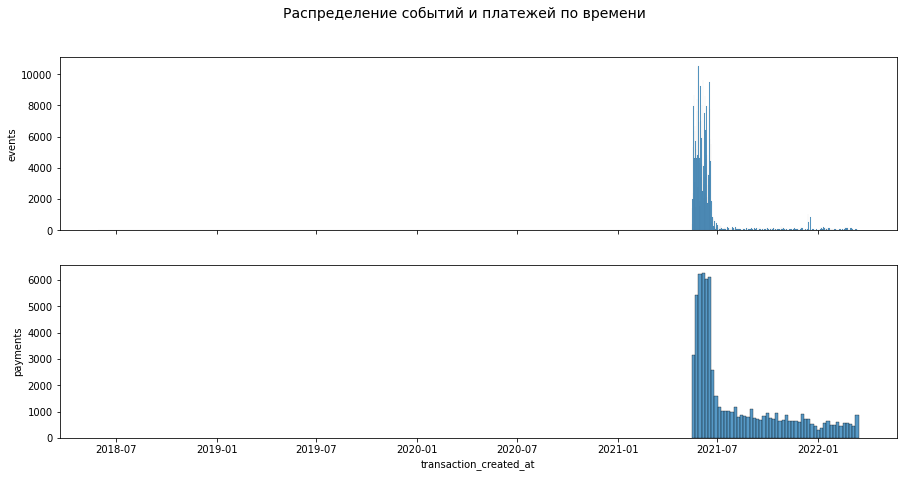

In [14]:
fig, ax = plt.subplots(2,1, figsize=(15,7), sharex='col')
fig.suptitle('Распределение событий и платежей по времени', fontsize=14)
sns.histplot(events.happened_at, ax = ax[0]).set_ylabel('events')
sns.histplot(payments.transaction_created_at, ax = ax[1]).set_ylabel('payments')

In [15]:
temp = events.copy()
temp['year'] = temp.happened_at.dt.year
temp['month'] = temp.happened_at.dt.month
temp.groupby(['year', 'month'], as_index=False).agg({'user_id':'nunique'})\
.rename(columns={'user_id':'unique_users'})

,year,month,unique_users
0,2018,5,1
1,2018,12,2
2,2019,1,1
3,2019,2,1
4,2019,6,1
5,2019,7,1
6,2019,8,1
7,2019,9,1
8,2019,10,1
9,2019,12,1


In [16]:
s = payments.copy()
s['year'] = s.transaction_created_at.dt.year
s['month'] = s.transaction_created_at.dt.month
s.groupby(['year', 'month'], as_index=False).agg({'user_id':'nunique'})\
.rename(columns={'user_id':'unique_users'})

,year,month,unique_users
0,2021,5,6573
1,2021,6,10707
2,2021,7,2616
3,2021,8,2330
4,2021,9,2197
5,2021,10,1998
6,2021,11,1795
7,2021,12,1599
8,2022,1,1284
9,2022,2,1209


Text(0, 0.5, 'payments')

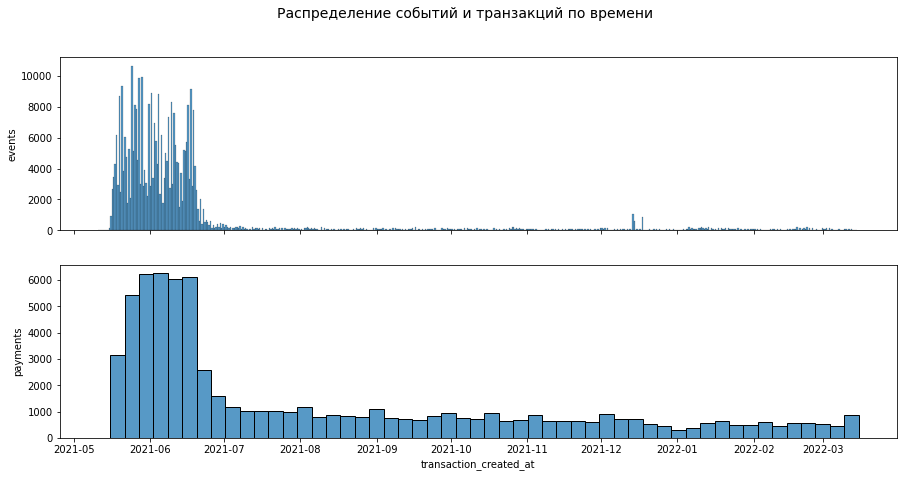

In [17]:
fig, ax = plt.subplots(2,1, figsize=(15,7), sharex='col')
fig.suptitle('Распределение событий и транзакций по времени', fontsize=14)
sns.histplot(events.query('happened_at >= "2021-05-01"').happened_at, ax = ax[0]).set_ylabel('events')
sns.histplot(payments.transaction_created_at, ax = ax[1]).set_ylabel('payments')

Судя по распределению событий и платежей по времени, продукт полноценно стартовал в середине мая 2021 года. Уберем из данных по событиям все записи до этого срока.

In [18]:
events = events.query('happened_at >= "2021-05-01"')

Далее рассмотрим распределение платежей по размеру, однако, прежде проверим данные по валюте.

In [19]:
payments.currency.value_counts(normalize=True)

RUB    0.886024
EUR    0.075111
USD    0.030821
PLN    0.006432
GBP    0.000432
UAH    0.000360
KRW    0.000302
CLP    0.000259
PEN    0.000115
JPY    0.000101
MXN    0.000029
UYU    0.000014
Name: currency, dtype: float64

Платежи проводились в разных валютах, в том числе, 11.3% платежей проведены в иностранной валюте.

In [20]:
users_foreign= payments[payments.currency != 'RUB'].user_id.unique()
len(users_foreign) *100 / payments.user_id.nunique(), len(users_foreign) *100 / events.user_id.nunique()

(12.463415981003921, 2.677247547536861)

Иностранные клиенты составляют 12.5% всех платящих пользователей и 2.7% всех (потенциальных) клиентов, совершивших хотя бы одно действие по взаимодействию с платформой. 

Для демонстрационного варианта ограничимся пользователями, платившими в рублях. Также сразу исключим клиентов, осуществивших платежи в иностранной валюте из данных по событиям.

In [21]:
payments.shape[0], events.shape[0]

(69497, 361652)

In [22]:
payments = payments[payments.user_id.isin(users_foreign) == False]
events = events[events.user_id.isin(users_foreign) == False]

In [23]:
payments.shape[0], events.shape[0]

(61352, 347780)

Добавим в данные по хронологии событий их описания.

In [24]:
events_full = events.merge(events_dict, how='left', left_on='event_id', right_on='id')\
.iloc[:,[2,0,4,5,1]].sort_values('happened_at')

Также добавим события оплаты на основании данных о платежах. При этом ограничимся клиентами, для которых у нас есть данные по событиям.

In [25]:
payments_to_events = payments[payments.user_id.isin(events_full.user_id)]\
.iloc[:,[1,2,5]].rename(columns={'transaction_created_at':'happened_at', 'is_gift':'name'})
payments_to_events.name = 'payment'
payments_to_events['event_id'] = 999
payments_to_events['description'] = 'Оплата'
payments_to_events = payments_to_events.iloc[:,[0,3,2,4,1]]
payments_to_events.head()

,happened_at,event_id,name,description,user_id
0,2021-05-16 03:41:25,999,payment,Оплата,12242732
1,2021-05-16 11:06:23,999,payment,Оплата,12241834
2,2021-05-16 11:33:06,999,payment,Оплата,12241501
3,2021-05-17 09:45:40,999,payment,Оплата,12242141
4,2021-05-17 13:35:35,999,payment,Оплата,12251367


In [26]:
events_full.shape[0] + payments_to_events.shape[0]

407986

In [27]:
events_full = pd.concat([events_full, payments_to_events]).sort_values('happened_at').reset_index(drop=True)

Рассмотрим получившийся датасет на наличие дубликатов.

In [28]:
events_full.groupby(list(events_full.columns), as_index=False).size().sort_values('size', ascending=False)

,happened_at,event_id,name,description,user_id,size
255685,2021-06-11 15:27:37,5,firstline_operator_send_wa_message,Отправка сообщения WA,12406621,23
345334,2021-07-10 11:46:22,9,student_answered_secondline_operator,Дозвон 2Л,12330927,7
282371,2021-06-15 14:10:01,9,student_answered_secondline_operator,Дозвон 2Л,12411857,7
139736,2021-05-30 15:29:13,9,student_answered_secondline_operator,Дозвон 2Л,12284148,7
381637,2021-12-02 10:49:08,9,student_answered_secondline_operator,Дозвон 2Л,12482365,7
...,...,...,...,...,...,...
134868,2021-05-29 17:03:02,999,payment,Оплата,12342575,1
134867,2021-05-29 17:02:58,4,student_answered_firstline_operator,Ученик ответил на звонок оператора 1л,12325991,1
134866,2021-05-29 17:02:42,3,student_created_order,Создание заявки,12347822,1
134865,2021-05-29 17:02:41,4,student_answered_firstline_operator,Ученик ответил на звонок оператора 1л,12341290,1


Рассмотрим примеры CJM пользователей, в записях которых есть дубликаты.

In [29]:
events_full[events_full.user_id == 12406621]

,happened_at,event_id,name,description,user_id
216312,2021-06-07 16:10:38,6,methodist_joined_introlesson,Выход МВУ на ВУ,12406621
216910,2021-06-07 17:01:15,999,payment,Оплата,12406621
257275,2021-06-11 15:27:37,5,firstline_operator_send_wa_message,Отправка сообщения WA,12406621
257276,2021-06-11 15:27:37,5,firstline_operator_send_wa_message,Отправка сообщения WA,12406621
257277,2021-06-11 15:27:37,5,firstline_operator_send_wa_message,Отправка сообщения WA,12406621
257278,2021-06-11 15:27:37,5,firstline_operator_send_wa_message,Отправка сообщения WA,12406621
257279,2021-06-11 15:27:37,5,firstline_operator_send_wa_message,Отправка сообщения WA,12406621
257280,2021-06-11 15:27:37,5,firstline_operator_send_wa_message,Отправка сообщения WA,12406621
257281,2021-06-11 15:27:37,5,firstline_operator_send_wa_message,Отправка сообщения WA,12406621
257282,2021-06-11 15:27:37,5,firstline_operator_send_wa_message,Отправка сообщения WA,12406621


In [30]:
events_full[events_full.user_id == 12312964]

,happened_at,event_id,name,description,user_id
83251,2021-05-25 11:25:31,3,student_created_order,Создание заявки,12312964
83252,2021-05-25 11:25:33,2,student_booked_introlesson,Назначение ВУ,12312964
83285,2021-05-25 11:27:19,3,student_created_order,Создание заявки,12312964
83288,2021-05-25 11:27:21,2,student_booked_introlesson,Назначение ВУ,12312964
359115,2021-08-16 12:48:38,2,student_booked_introlesson,Назначение ВУ,12312964
359116,2021-08-16 12:49:47,2,student_booked_introlesson,Назначение ВУ,12312964
359934,2021-08-19 14:17:30,2,student_booked_introlesson,Назначение ВУ,12312964
359936,2021-08-19 14:18:44,2,student_booked_introlesson,Назначение ВУ,12312964
359975,2021-08-19 16:34:10,4,student_answered_firstline_operator,Ученик ответил на звонок оператора 1л,12312964
359976,2021-08-19 16:34:10,4,student_answered_firstline_operator,Ученик ответил на звонок оператора 1л,12312964


In [31]:
events_full.groupby(list(events_full.columns), as_index=False).size().query('size >= 2').shape[0]

3242

In [32]:
round(events_full.groupby(list(events_full.columns), as_index=False).size().query('size >= 2').shape[0] *100
      / events_full.groupby(list(events_full.columns), as_index=False).size().shape[0], 1)

0.8

Дубликаты в событиях нельзя объяснить логически никакими факторами, кроме технических сбоев. Доля уникальных записей, по которым есть повторения, составляет 0,8 % (3377 уникальных записей). Исключим их из дальнейшего анализа.

In [33]:
events_full.shape[0]

407986

In [34]:
events_full = events_full.drop_duplicates()

In [35]:
events_full.shape[0]

403844

In [36]:
events_full.description.value_counts()

Создание заявки                          96578
Назначение ВУ                            73428
Оплата                                   59948
Назначение задачи на звонок 1Л           53607
Ученик ответил на звонок оператора 1л    47024
Выход МВУ на ВУ                          22937
Успешный ВУ                              19469
Дозвон 2Л                                14976
Назначена задача на вторую линию         14506
Отправка сообщения WA                      720
Переход на ДУ (ДУ начался)                 397
ДУ завершен                                225
У ответил на сообщение WA                   29
Name: description, dtype: int64

Согласно условию задания ВУ и ДУ - это разные воронки. К тому же отправка сообщения в WhatsApp судя по пояснениям заказчика является экспериментальным каналои взаимодействя с клиентами на 1-ой линии. 

Принимая во внимание отношение кол-ва назначенных ВУ к кол-ву переходов на ДУ (около 76 тыс. против около 0,4 тыс.), а также отношение кол-ва отправленных сообщений в WA к кол-ву звонков 1 линии (около 56 тыс. против около 0,7 тыс.), предоставим заказчику сначала сведения по основной воронке, а уже в ходе совместного обсуждения доработок к отчету обсудим, какие показатели он хочет видеть по дополнительной воронке.

Согласно условию, основная воронка выглядит так:

3 Пользователь создает заявку

8 Назначение задачи на звонок 1Л (звонок от первой линии для назначения ВУ)

4 Ученик ответил на звонок 1Л

2 Назначение ВУ

6 Выход МВУ на ВУ

999 Оплата

7 Успешный ВУ

In [37]:
events_full.shape[0]

403844

In [38]:
minor_funnel_users_list = events_full[events_full.event_id.isin([5,13,10,11])].user_id.unique()
events_full = events_full[events_full.user_id.isin(minor_funnel_users_list) == False]

In [39]:
events_full.shape[0]

394509

In [40]:
events_full.description.value_counts()

Создание заявки                          94893
Назначение ВУ                            72543
Оплата                                   57924
Назначение задачи на звонок 1Л           52315
Ученик ответил на звонок оператора 1л    45896
Выход МВУ на ВУ                          22625
Успешный ВУ                              19202
Дозвон 2Л                                14777
Назначена задача на вторую линию         14334
Name: description, dtype: int64

Смотря на получившуюся общую воронку возникают следующие вопросы:

1) Назначенных ВУ больше чем звонков

Вводный урок может быть назначен не по телефону?

2) Почему выходов МВУ (методиста) на ВУ кратно меньше, чем назначенных ВУ (24 тыс. против 75 тыс.)?

Вводный урок может проходить без методиста или невыход методиста означает невыход на урок ученика

3) Успешный ВУ - это оплата? 

Необходимо сопоставить данные по платежам с данными по событиям

4) Дозвонов на 2 линии больше чем назначенных звонков

5) Какое нормативное время рассмотрения заявки? 

Например, один клиент может создать 2 заявки на сайте в течение дня, но если регламентный срок рассмотрения заявки составляет 1 сутки, целесообразно считать эти 2 заявки за одну.

Постараемся найти ответы на поставленные вопросы с помощью данных, подсчитав кол-во различных действий по каждому пользователю. Для этого создадим сводную таблицу ученики-события.

In [41]:
user_events_pivot = events_full.pivot_table(index='user_id', columns='description', values='happened_at', 
                                            aggfunc='count').reset_index().fillna(0).astype(int)\
.iloc[:,[0,7,5,9,4,1,6,8,3,2]]
user_events_pivot['Всего событий'] = user_events_pivot[list(user_events_pivot.columns)[1:10]].sum(1)
user_events_pivot = user_events_pivot.sort_values('Всего событий', ignore_index=True)
user_events_pivot.iloc[[0,1,
                        int(user_events_pivot.shape[0] / 2),int(user_events_pivot.shape[0] / 2)+1,
                        user_events_pivot.shape[0]-2, user_events_pivot.shape[0]-1],:]

description,user_id,Создание заявки,Назначение задачи на звонок 1Л,Ученик ответил на звонок оператора 1л,Назначение ВУ,Выход МВУ на ВУ,Оплата,Успешный ВУ,Назначена задача на вторую линию,Дозвон 2Л,Всего событий
0,12359594,1,0,0,0,0,0,0,0,0,1
1,12264486,1,0,0,0,0,0,0,0,0,1
40492,12291803,1,1,1,0,0,0,0,0,0,3
40493,12259928,1,1,1,0,0,0,0,0,0,3
80983,12258397,2,1,1,1,1,73,1,1,2,83
80984,12373656,5,4,4,3,3,64,3,3,2,91


1. Почему назначенных ВУ больше, чем назначенных звонков 1Л?

Выделим пользователей, для которых кол-во назначенных ВУ превышает кол-во назначенных звонков на 1Л

In [42]:
user_events_pivot[user_events_pivot['Назначение ВУ'] > user_events_pivot['Назначение задачи на звонок 1Л']].shape[0]

31688

In [43]:
round(user_events_pivot[user_events_pivot['Назначение ВУ'] > user_events_pivot['Назначение задачи на звонок 1Л']].shape[0] \
*100 / user_events_pivot.shape[0], 1)

39.1

Таких пользователей около 32 тыс., что составляет 39.1% всех пользователей - это значительная часть.

Рассмотрим на примерах CJM данных пользователей.

In [44]:
s = user_events_pivot[user_events_pivot['Назначение ВУ'] > user_events_pivot['Назначение задачи на звонок 1Л']]
s.iloc[[0,1,
       int(s.shape[0] / 2),int(s.shape[0] / 2)+1,
       s.shape[0]-2, s.shape[0]-1],:]

description,user_id,Создание заявки,Назначение задачи на звонок 1Л,Ученик ответил на звонок оператора 1л,Назначение ВУ,Выход МВУ на ВУ,Оплата,Успешный ВУ,Назначена задача на вторую линию,Дозвон 2Л,Всего событий
876,12367556,0,0,0,1,0,0,0,0,0,1
4210,12407550,1,0,0,1,0,0,0,0,0,2
55271,12395347,1,0,1,2,0,0,0,0,1,5
55275,12442241,1,1,1,2,0,0,0,0,0,5
80976,12321417,6,1,0,3,3,49,3,2,0,67
80980,12401523,2,2,2,3,2,55,2,2,1,71


In [45]:
events_full[events_full.user_id == 12367556]

,happened_at,event_id,name,description,user_id
162353,2021-06-01 18:26:44,2,student_booked_introlesson,Назначение ВУ,12367556


Мы видим, что назначение ВУ в случае со студентом 12367556 было единственным событием во всей цепочки, не было ни создания заявки, ни звонка оператора. Рассмотрим вопрос необходимости создания заявки отдельно.

Выявим пользователей, не создавших заявку

In [46]:
user_events_pivot[user_events_pivot['Создание заявки'] == 0]

description,user_id,Создание заявки,Назначение задачи на звонок 1Л,Ученик ответил на звонок оператора 1л,Назначение ВУ,Выход МВУ на ВУ,Оплата,Успешный ВУ,Назначена задача на вторую линию,Дозвон 2Л,Всего событий
45,12313320,0,0,0,0,1,0,0,0,0,1
252,12466640,0,0,0,0,1,0,0,0,0,1
324,12465495,0,0,0,0,1,0,0,0,0,1
331,12386510,0,0,0,0,1,0,0,0,0,1
571,12267429,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
70040,12462349,0,1,1,3,1,0,1,1,1,9
70181,12245751,0,1,1,2,1,1,1,1,1,9
71125,12413607,0,0,0,0,1,8,0,0,0,9
75701,12359431,0,0,0,0,1,11,0,0,0,12


In [47]:
round(user_events_pivot[user_events_pivot['Создание заявки'] == 0].shape[0] *100 / user_events_pivot.shape[0],1)

0.1

97 пользователей (0.1%) миновали шаг Создание заявки, при этом по ним есть сведения о других шагах.

Примеры с разным количеством событий:

In [48]:
s = user_events_pivot[user_events_pivot['Создание заявки'] == 0]
s.iloc[[0,1,
       int(s.shape[0] / 2),int(s.shape[0] / 2)+1,
       s.shape[0]-2, s.shape[0]-1],:]

description,user_id,Создание заявки,Назначение задачи на звонок 1Л,Ученик ответил на звонок оператора 1л,Назначение ВУ,Выход МВУ на ВУ,Оплата,Успешный ВУ,Назначена задача на вторую линию,Дозвон 2Л,Всего событий
45,12313320,0,0,0,0,1,0,0,0,0,1
252,12466640,0,0,0,0,1,0,0,0,0,1
4631,12407114,0,0,0,0,1,1,0,0,0,2
4710,12406640,0,0,0,0,1,1,0,0,0,2
75701,12359431,0,0,0,0,1,11,0,0,0,12
79310,12314704,0,0,0,0,1,17,0,0,0,18


Рассмотрим этих пользователей на предмет первичного обзвона операторами обеих линий, несмотря на отсутствие данных о холодных звонках в условии задачи.

In [49]:
user_events_pivot[user_events_pivot['Создание заявки'] +
                  user_events_pivot['Назначение задачи на звонок 1Л'] +
                  user_events_pivot['Ученик ответил на звонок оператора 1л'] +
                  user_events_pivot['Назначена задача на вторую линию'] +
                  user_events_pivot['Дозвон 2Л']== 0]

description,user_id,Создание заявки,Назначение задачи на звонок 1Л,Ученик ответил на звонок оператора 1л,Назначение ВУ,Выход МВУ на ВУ,Оплата,Успешный ВУ,Назначена задача на вторую линию,Дозвон 2Л,Всего событий
45,12313320,0,0,0,0,1,0,0,0,0,1
252,12466640,0,0,0,0,1,0,0,0,0,1
324,12465495,0,0,0,0,1,0,0,0,0,1
331,12386510,0,0,0,0,1,0,0,0,0,1
571,12267429,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
63978,12265694,0,0,0,0,1,6,0,0,0,7
65344,12415253,0,0,0,0,1,6,0,0,0,7
71125,12413607,0,0,0,0,1,8,0,0,0,9
75701,12359431,0,0,0,0,1,11,0,0,0,12


80 из указанных 97 пользователей, не создавших заявку, также не получали звонки операторов.

Посмотрим, что было первым шагом для этих пользователей.

In [50]:
def first_step_definition(row):
    not_zero_count = 0
    for i in range(len(row)):
        if row[i] > 0:
            not_zero_count +=1
            if not_zero_count == 2:
                return user_events_pivot.columns[i]

In [51]:
user_events_pivot[user_events_pivot['Создание заявки'] == 0].apply(first_step_definition, 1)\
.value_counts()

Выход МВУ на ВУ                          76
Назначение задачи на звонок 1Л           11
Ученик ответил на звонок оператора 1л     5
Назначение ВУ                             5
dtype: int64

В 78% таких случаев (76 из 97) первым шагом стал выход методиста на ВУ, при этом событие назначения ВУ отсутствовало.

Принимая во внимание количество таких случаев и невозможность восстановления логической последовательности действий данных пользователей, исключим их из анализа.

In [52]:
events_full.shape[0]

394509

In [53]:
delete_users = user_events_pivot[user_events_pivot['Создание заявки'] == 0].user_id
events_full = events_full[events_full.user_id.isin(delete_users) == False]

In [54]:
events_full.shape[0]

394237

In [55]:
user_events_pivot.shape[0]

80985

In [56]:
user_events_pivot = user_events_pivot[user_events_pivot['Создание заявки'] != 0]

In [57]:
user_events_pivot.shape[0]

80888

Вернемся к вопросу о превышении кол-ва назначенных ВУ над кол-вом назначенных звонков 1 Л. Рассмотрим CJM данных пользователей на новых примерах.

In [58]:
s = user_events_pivot[user_events_pivot['Назначение ВУ'] > user_events_pivot['Назначение задачи на звонок 1Л']]
s.iloc[[0,1,
       int(s.shape[0] / 2),int(s.shape[0] / 2)+1,
       s.shape[0]-2, s.shape[0]-1],:]

description,user_id,Создание заявки,Назначение задачи на звонок 1Л,Ученик ответил на звонок оператора 1л,Назначение ВУ,Выход МВУ на ВУ,Оплата,Успешный ВУ,Назначена задача на вторую линию,Дозвон 2Л,Всего событий
4210,12407550,1,0,0,1,0,0,0,0,0,2
4211,12407783,1,0,0,1,0,0,0,0,0,2
55271,12395347,1,0,1,2,0,0,0,0,1,5
55275,12442241,1,1,1,2,0,0,0,0,0,5
80976,12321417,6,1,0,3,3,49,3,2,0,67
80980,12401523,2,2,2,3,2,55,2,2,1,71


Мы видим, что есть пользователи, ответившие на звонок оператора, но не получившие звонок. Рассмотрим примеры и оценим масштабы

In [59]:
user_events_pivot[user_events_pivot['Ученик ответил на звонок оператора 1л'] > 
                        user_events_pivot['Назначение задачи на звонок 1Л']].shape[0]

5240

In [60]:
round(user_events_pivot[user_events_pivot['Ученик ответил на звонок оператора 1л'] > 
                        user_events_pivot['Назначение задачи на звонок 1Л']].shape[0] *100 /
      user_events_pivot.shape[0], 1)

6.5

Количество пользователей, по которым число отвеченных звонков превышает число полученных составляет около 5 тыс., что значительно. Рассмотрим примеры:

In [61]:
s = user_events_pivot[user_events_pivot['Ученик ответил на звонок оператора 1л'] > 
                        user_events_pivot['Назначение задачи на звонок 1Л']]
s.iloc[[0,1,
       int(s.shape[0] / 2),int(s.shape[0] / 2)+1,
       s.shape[0]-2, s.shape[0]-1],:]

description,user_id,Создание заявки,Назначение задачи на звонок 1Л,Ученик ответил на звонок оператора 1л,Назначение ВУ,Выход МВУ на ВУ,Оплата,Успешный ВУ,Назначена задача на вторую линию,Дозвон 2Л,Всего событий
4285,12336181,1,0,1,0,0,0,0,0,0,2
4382,12408918,1,0,1,0,0,0,0,0,0,2
60620,12347064,1,0,1,1,1,1,1,0,0,6
60638,12375267,1,0,1,1,1,1,1,0,0,6
80952,12380498,4,2,3,1,1,32,1,1,2,47
80979,12277441,4,3,4,2,2,48,2,2,2,69


In [62]:
events_full[events_full.user_id == 12404817]

,happened_at,event_id,name,description,user_id
211793,2021-06-07 10:38:18,3,student_created_order,Создание заявки,12404817
211816,2021-06-07 10:39:33,2,student_booked_introlesson,Назначение ВУ,12404817
217374,2021-06-07 17:40:14,6,methodist_joined_introlesson,Выход МВУ на ВУ,12404817
217423,2021-06-07 17:45:00,7,student_pass_introlesson_succesfully,Успешный ВУ,12404817
217457,2021-06-07 17:47:06,4,student_answered_firstline_operator,Ученик ответил на звонок оператора 1л,12404817
217840,2021-06-07 18:19:40,999,payment,Оплата,12404817


Ученик ответил на звонок оператора 1л уже после ВУ, перед оплатой. Путь от создания заявки до признания прошедшего ВУ успешным прошел без звонков операторов.

In [63]:
events_full[events_full.user_id == 12318497]

,happened_at,event_id,name,description,user_id
92046,2021-05-25 21:12:35,3,student_created_order,Создание заявки,12318497
92051,2021-05-25 21:12:52,2,student_booked_introlesson,Назначение ВУ,12318497
105297,2021-05-26 22:05:04,6,methodist_joined_introlesson,Выход МВУ на ВУ,12318497
105360,2021-05-26 22:15:00,7,student_pass_introlesson_succesfully,Успешный ВУ,12318497
105431,2021-05-26 22:35:04,999,payment,Оплата,12318497
334100,2021-06-21 17:00:32,4,student_answered_firstline_operator,Ученик ответил на звонок оператора 1л,12318497


Ученик ответил на звонок оператора уже после оплаты, на следующий день.

In [64]:
events_full[events_full.user_id == 12380498]

,happened_at,event_id,name,description,user_id
176687,2021-06-03 10:06:33,8,firstline_operator_assigned_at_task,Назначение задачи на звонок 1Л,12380498
179601,2021-06-03 13:00:22,3,student_created_order,Создание заявки,12380498
179716,2021-06-03 13:06:38,4,student_answered_firstline_operator,Ученик ответил на звонок оператора 1л,12380498
179831,2021-06-03 13:13:49,3,student_created_order,Создание заявки,12380498
219464,2021-06-07 21:16:53,4,student_answered_firstline_operator,Ученик ответил на звонок оператора 1л,12380498
224178,2021-06-08 13:25:37,8,firstline_operator_assigned_at_task,Назначение задачи на звонок 1Л,12380498
226580,2021-06-08 16:25:38,2,student_booked_introlesson,Назначение ВУ,12380498
249998,2021-06-10 20:59:20,999,payment,Оплата,12380498
250000,2021-06-10 20:59:47,999,payment,Оплата,12380498
260181,2021-06-11 20:17:11,6,methodist_joined_introlesson,Выход МВУ на ВУ,12380498


Первый звонок поступил ученику до создания заявки. Также видно, что много оплат с интервалами от нескольких секунд, до нескольких минут, возможно, это дубликаты.

Как видно из представленных примеров, CJM пользователей довольно запутан.

С помощью библиотеки retentioneering рассмотрим хронологию шагов по всем пользователям укрупненно.

## 1. Определение стандартной воронки с помощью библиотеки Retentioneering

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Создание заявки,0.660333,0.332929,0.049043,0.013562,0.017246,0.015552,0.011695,0.012116,0.011584,0.009099,0.007875,0.005934,0.004500,0.003968,0.002732
Назначение ВУ,0.000025,0.366532,0.132541,0.180707,0.075697,0.046360,0.028855,0.016171,0.010842,0.007937,0.006157,0.005291,0.003968,0.003301,0.002707
Ученик ответил на звонок оператора 1л,0.000161,0.044593,0.360523,0.067797,0.025554,0.014217,0.009692,0.007467,0.004871,0.005489,0.005625,0.004376,0.003338,0.002782,0.002287
Выход МВУ на ВУ,0.000000,0.000099,0.069775,0.051330,0.073657,0.033108,0.014638,0.009037,0.005823,0.004290,0.003412,0.002559,0.002287,0.001978,0.001508
Успешный ВУ,0.000000,0.000012,0.010941,0.059675,0.040253,0.056461,0.025146,0.012585,0.008419,0.004982,0.003857,0.003140,0.002213,0.001941,0.001743
Оплата,0.001360,0.027025,0.023959,0.021635,0.056980,0.052517,0.069256,0.061344,0.052047,0.046707,0.039227,0.034418,0.030140,0.025022,0.022204
Дозвон 2Л,0.000841,0.004475,0.006936,0.009828,0.006614,0.019162,0.029040,0.030647,0.024614,0.014366,0.009111,0.006293,0.004834,0.003363,0.002559
Назначена задача на вторую линию,0.000000,0.001360,0.001805,0.001521,0.018050,0.032811,0.036656,0.028867,0.016344,0.010249,0.007207,0.004908,0.003672,0.002782,0.002225
Назначение задачи на звонок 1Л,0.337281,0.171447,0.077638,0.018532,0.008654,0.004710,0.003486,0.003820,0.004500,0.003907,0.002646,0.002077,0.001471,0.001137,0.001026
ENDED,0.000000,0.051528,0.266838,0.575413,0.677295,0.725101,0.771536,0.817946,0.860956,0.892975,0.914882,0.931003,0.943576,0.953726,0.961008


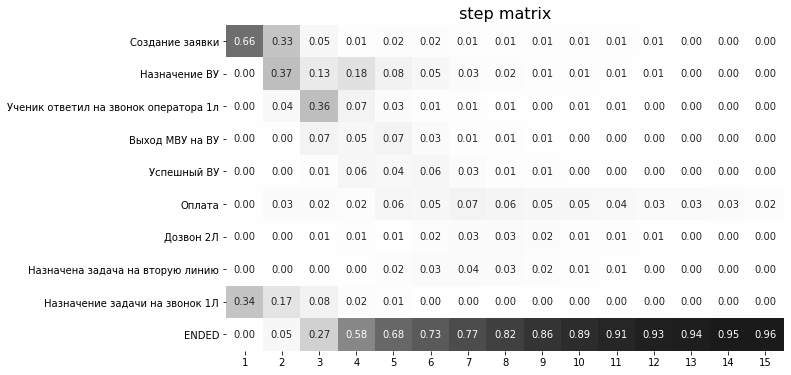

In [65]:
# Зададим необходимые поля для работы с библиотекой retentioneering
rete.config.update({'user_col': 'user_id',
                               'event_col': 'description',
                               'event_time_col': 'happened_at'
                               })

# Step matrix для 15 первых событий
events_full.rete.step_matrix(max_steps=15, thresh=0.025)


1) Маршрут двух третей пользователей начинается с создания заявки, одной трети - с звонка оператора 1Л. При этом у нас нет сведений о холодных звонках в описании стандартного CJM.

2) Вторым шагом идет или Назначение ВУ - 36%, или Создание заявки - 33%, или Назначение на звонок 1Л - 17%, или ответ ученика на звонок - 5%, или уже оплата - 3%. 

3) На втором шаге 26% пользователей завершают взаимодействие с платформой, на четвертом - 66%.

Таким образом, CJM пользователей в основном ограничивается четырьмя шагами, при этом их последовательность очень вариативна. Для демонстрации руководителю отдела продаж необходимо максимально упростить воронку.

Удалим клиентов, события которых начинаются со звонков, так как это не соответствует стандартной воронке.

In [66]:
events_full_clean = events_full[events_full.user_id.isin(events_full.groupby('user_id').description.first()\
.reset_index().query('description == "Создание заявки"').user_id.unique())]

Также удалим дубликаты событий по каждому клиенту, так как мы анализируем воронку привлечения клиентов, а не удержания постоянных клиентов, и нам важно, дошел ли клиент до определенного события воронки хотя бы раз или нет, а не периодичность этих действий.

In [67]:
events_full_clean.shape[0]

265835

In [68]:
events_full_clean = events_full_clean.drop_duplicates(subset=['user_id', 'description'])

In [69]:
events_full_clean.shape[0]

194055

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Создание заявки,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,0,0,0,0,0,0,0,0,0
Назначение ВУ,0.0,0.556644,0.030723,0.089379,0.002303,0.000094,0.000019,0.000000,0.000000,0.0,0,0,0,0,0,0,0,0,0,0
Успешный ВУ,0.0,0.000000,0.025874,0.127197,0.039784,0.056428,0.003538,0.000112,0.000019,0.0,0,0,0,0,0,0,0,0,0,0
Оплата,0.0,0.041413,0.002827,0.002509,0.090240,0.025930,0.042143,0.004606,0.002565,0.0,0,0,0,0,0,0,0,0,0,0
Назначена задача на вторую линию,0.0,0.002116,0.002190,0.001311,0.046393,0.074458,0.039223,0.025574,0.001254,0.0,0,0,0,0,0,0,0,0,0,0
Дозвон 2Л,0.0,0.006721,0.010353,0.012525,0.008930,0.042892,0.062251,0.032670,0.022092,0.0,0,0,0,0,0,0,0,0,0,0
Ученик ответил на звонок оператора 1л,0.0,0.067044,0.229794,0.071368,0.012038,0.007227,0.008575,0.007901,0.003969,0.0,0,0,0,0,0,0,0,0,0,0
Назначение задачи на звонок 1Л,0.0,0.247019,0.115384,0.008949,0.001797,0.005766,0.006085,0.004737,0.000842,0.0,0,0,0,0,0,0,0,0,0,0
Выход МВУ на ВУ,0.0,0.000131,0.156703,0.060004,0.071406,0.010615,0.000431,0.000019,0.000000,0.0,0,0,0,0,0,0,0,0,0,0
ENDED,0.0,0.078913,0.426151,0.626758,0.727108,0.776590,0.837736,0.924382,0.969258,1.0,1,1,1,1,1,1,1,1,1,1


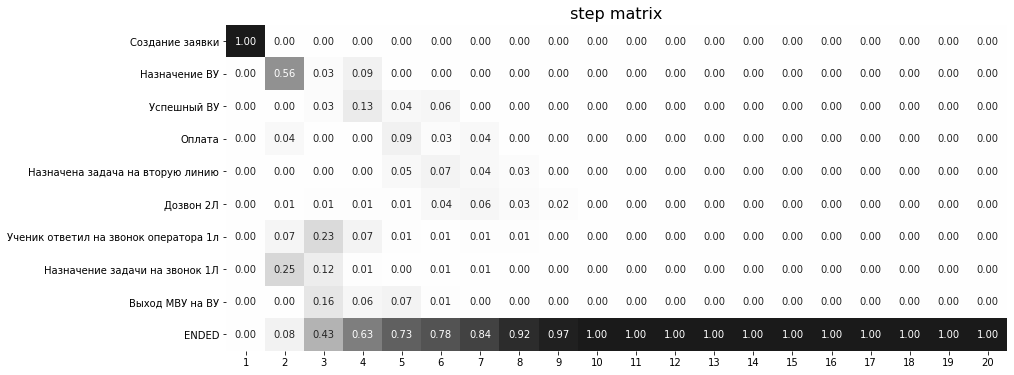

In [70]:
rete.config.update({'user_col': 'user_id',
                               'event_col': 'description',
                               'event_time_col': 'happened_at'
                               })
events_full_clean.rete.step_matrix(max_steps=20, thresh=0.025)

Назначение ВУ в два раза чаще следует за созданием заявки для оставшихся пользователей, оставим только этот маршрут на первых двух шагах. Пользователей с иным началом маршрута исключим.

In [71]:
events_full_clean.shape[0]

194055

In [72]:
ev1 = events_full_clean.groupby('user_id').description.count().reset_index().query('description < 2').user_id.unique()
scnd = events_full_clean.groupby('user_id').description.nth(1).reset_index().query('description == "Назначение ВУ"')\
.user_id.unique()
events_full_clean = events_full_clean[events_full_clean.user_id.isin(np.append(ev1,scnd))]

In [73]:
events_full_clean.shape[0]

119675

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Создание заявки,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Назначение ВУ,0.0,0.875836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Успешный ВУ,0.0,0.000000,0.040652,0.195864,0.038089,0.024155,0.001119,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Оплата,0.0,0.000000,0.002416,0.000766,0.140484,0.035938,0.025275,0.003918,0.001679,0.0,0.0,0.0,0.0,0.0,0.0
Назначена задача на вторую линию,0.0,0.000000,0.000324,0.000147,0.072230,0.104575,0.029546,0.013374,0.000648,0.0,0.0,0.0,0.0,0.0,0.0
Дозвон 2Л,0.0,0.000000,0.003947,0.010487,0.007688,0.064453,0.088727,0.024656,0.013168,0.0,0.0,0.0,0.0,0.0,0.0
Ученик ответил на звонок оператора 1л,0.0,0.000000,0.070846,0.087106,0.015259,0.010752,0.012137,0.011842,0.006157,0.0,0.0,0.0,0.0,0.0,0.0
Назначение задачи на звонок 1Л,0.0,0.000000,0.098448,0.006952,0.001974,0.008867,0.009456,0.007306,0.001296,0.0,0.0,0.0,0.0,0.0,0.0
Выход МВУ на ВУ,0.0,0.000000,0.246649,0.076384,0.030872,0.002798,0.000088,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
ENDED,0.0,0.124164,0.536719,0.622294,0.693404,0.748461,0.833652,0.938905,0.977052,1.0,1.0,1.0,1.0,1.0,1.0


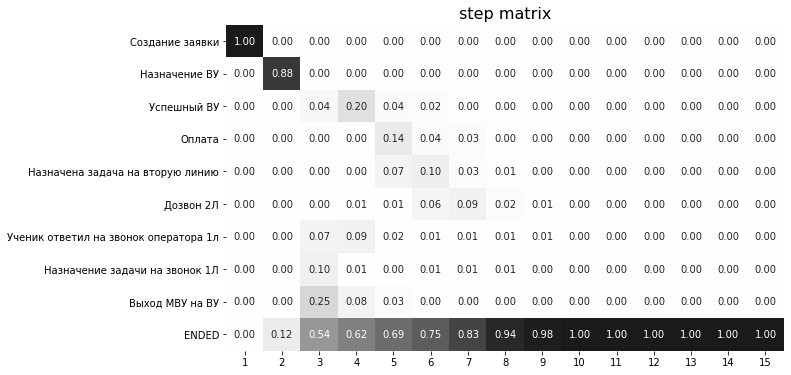

In [74]:
rete.config.update({'user_col': 'user_id',
                               'event_col': 'description',
                               'event_time_col': 'happened_at'
                               })
events_full_clean.rete.step_matrix(max_steps=15, thresh=0.025)

Теперь оставим только пользователей с третьим шагом Выход МВУ на ВУ, так как их большинство

In [75]:
events_full_clean.shape[0]

119675

In [76]:
ev1 = events_full_clean.groupby('user_id').description.count().reset_index().query('description < 3').user_id.unique()
scnd = events_full_clean.groupby('user_id').description.nth(2).reset_index().query('description == "Выход МВУ на ВУ"')\
.user_id.unique()
events_full_clean = events_full_clean[events_full_clean.user_id.isin(np.append(ev1,scnd))]

In [77]:
events_full_clean.shape[0]

81229

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Создание заявки,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Назначение ВУ,0.0,0.841452,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Успешный ВУ,0.0,0.000000,0.000000,0.243069,0.013918,0.001053,0.000188,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Оплата,0.0,0.000000,0.000000,0.000188,0.150536,0.020275,0.007485,0.001881,0.000564,0.0,0.0,0.0,0.0,0.0,0.0
Назначена задача на вторую линию,0.0,0.000000,0.000000,0.000038,0.073500,0.098890,0.011774,0.002106,0.000188,0.0,0.0,0.0,0.0,0.0,0.0
Дозвон 2Л,0.0,0.000000,0.000000,0.010645,0.004514,0.063908,0.084634,0.009140,0.003235,0.0,0.0,0.0,0.0,0.0,0.0
Выход МВУ на ВУ,0.0,0.000000,0.314651,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
ENDED,0.0,0.158548,0.685349,0.723980,0.745308,0.796727,0.876697,0.968516,0.989430,1.0,1.0,1.0,1.0,1.0,1.0
THRESHOLDED_2,0.0,0.000000,0.000000,0.022080,0.012225,0.019146,0.019221,0.018356,0.006583,0.0,0.0,0.0,0.0,0.0,0.0


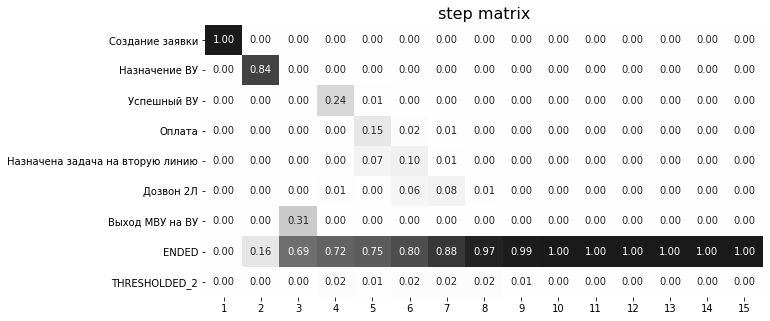

In [78]:
rete.config.update({'user_col': 'user_id',
                               'event_col': 'description',
                               'event_time_col': 'happened_at'
                               })
events_full_clean.rete.step_matrix(max_steps=15, thresh=0.025)

Аналогично вычистим остальные шаги.

In [79]:
events_full_clean.shape[0]

81229

In [80]:
ev1 = events_full_clean.groupby('user_id').description.count().reset_index().query('description < 4').user_id.unique()
scnd = events_full_clean.groupby('user_id').description.nth(3).reset_index().query('description == "Успешный ВУ"')\
.user_id.unique()
events_full_clean = events_full_clean[events_full_clean.user_id.isin(np.append(ev1,scnd))]

In [81]:
events_full_clean.shape[0]

76364

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Создание заявки,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Назначение ВУ,0.0,0.836043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Успешный ВУ,0.0,0.000000,0.000000,0.251323,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
Оплата,0.0,0.000000,0.000000,0.000000,0.155555,0.012564,0.006613,0.001517,0.000545,0.0,0.0,0.0,0.0,0.0,0.0
Назначена задача на вторую линию,0.0,0.000000,0.000000,0.000000,0.075969,0.096585,0.006302,0.001478,0.000194,0.0,0.0,0.0,0.0,0.0,0.0
Дозвон 2Л,0.0,0.000000,0.000000,0.000000,0.004123,0.065816,0.084021,0.005485,0.002995,0.0,0.0,0.0,0.0,0.0,0.0
Выход МВУ на ВУ,0.0,0.000000,0.291271,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
ENDED,0.0,0.163957,0.708729,0.748677,0.755018,0.805586,0.884122,0.973549,0.989925,1.0,1.0,1.0,1.0,1.0,1.0
THRESHOLDED_2,0.0,0.000000,0.000000,0.000000,0.009336,0.019449,0.018944,0.017971,0.006340,0.0,0.0,0.0,0.0,0.0,0.0


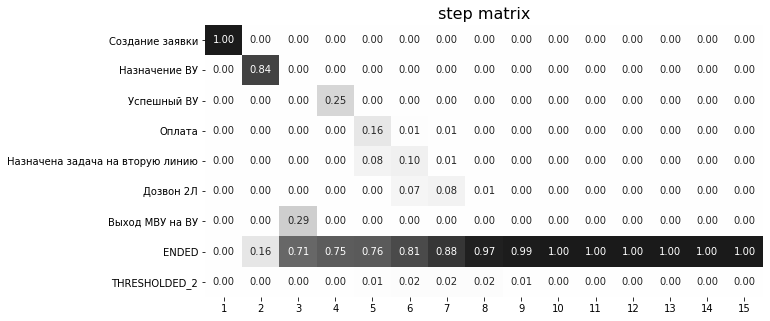

In [82]:
rete.config.update({'user_col': 'user_id',
                               'event_col': 'description',
                               'event_time_col': 'happened_at'
                               })
events_full_clean.rete.step_matrix(max_steps=15, thresh=0.025)

In [83]:
events_full_clean.shape[0]

76364

In [84]:
ev1 = events_full_clean.groupby('user_id').description.count().reset_index().query('description < 5').user_id.unique()
scnd = events_full_clean.groupby('user_id').description.nth(4).reset_index().query('description == "Оплата"')\
.user_id.unique()
events_full_clean = events_full_clean[events_full_clean.user_id.isin(np.append(ev1,scnd))]

In [85]:
events_full_clean.shape[0]

61791

,1,2,3,4,5,6,7
Создание заявки,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Назначение ВУ,0.0,0.819941,0.000000,0.000000,0.000000,0.000000,0.000000
Успешный ВУ,0.0,0.000000,0.000000,0.177795,0.000000,0.000000,0.000000
Оплата,0.0,0.000000,0.000000,0.000000,0.170789,0.000043,0.000000
Назначена задача на вторую линию,0.0,0.000000,0.000000,0.000000,0.000043,0.099406,0.002307
Дозвон 2Л,0.0,0.000000,0.000000,0.000000,0.000000,0.005468,0.084028
Выход МВУ на ВУ,0.0,0.000000,0.221667,0.000000,0.000000,0.000000,0.000000
ENDED,0.0,0.180059,0.778333,0.822205,0.829168,0.876885,0.901021
THRESHOLDED_2,0.0,0.000000,0.000000,0.000000,0.000000,0.018198,0.012645


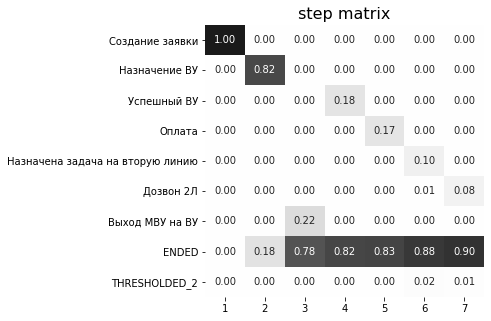

In [86]:
rete.config.update({'user_col': 'user_id',
                               'event_col': 'description',
                               'event_time_col': 'happened_at'
                               })
events_full_clean.rete.step_matrix(max_steps=7, thresh=0.025)

Таким образом, путем выделения основных паттернов поведения пользователей на каждом шаге получилась стандартная воронка, отличающаяся от заявленной в условии отсутствием звонков на 1 линии.  Это позволяет сделать следующий вывод:

Звонки не являются обязательным условием для прохождения воронки (от создания заявки до первой оплаты) для большей части пользователей, поэтому в дальнейшем при расчете показателя воронки в демонстационном варианте для заказчика звонки 1 линии не будут выделяться как отдельный шаг воронки, а будут рассматриваться лишь как дополнительный инструмент.

In [87]:
print('Количество пользователей, попавших в стандартную воронку:', events_full_clean.user_id.nunique())
print('Доля пользователей, попавших в стандартную воронку:', round(events_full_clean.user_id.nunique() *100
                                                                           / events_full.user_id.nunique(), 1), '%')

Количество пользователей, попавших в стандартную воронку: 23409
Доля пользователей, попавших в стандартную воронку: 28.9 %


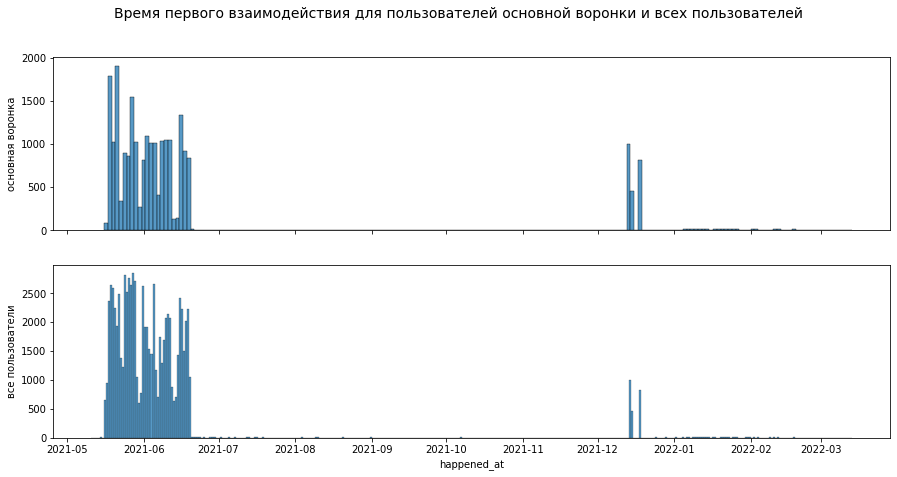

In [88]:
fig, ax = plt.subplots(2,1, figsize=(15,7), sharex='col')
fig.suptitle('Время первого взаимодействия для пользователей основной воронки и всех пользователей', fontsize=14)
sns.histplot(events_full_clean.groupby('user_id').happened_at.first(), ax = ax[0]).set_ylabel('основная воронка')
sns.histplot(events_full.groupby('user_id').happened_at.first(), ax = ax[1]).set_ylabel('все пользователи')
plt.show()

Как видно, основная воронка была превалирующим маршрутом на протяжении всего времени существования продукта.

## 2. Выбор и расчет метрик

### 2.1. Обоснование выбора метрик

В задании предлагалось выбрать 3 метрики, которые давали бы руководителю отдела продаж информацию о текущем положении дел ежедневно. Главным показателем работы отдела продаж является динамика объема продаж. Данный показатель напрямую зависит от: 

1) прироста новых платящих клиентов

2) удержания существующих плятящих клиентов

3) дохода от клиентов

Мы не знаем, сколько длится обучение и какая периодичность платежей предполагается для каждого продукта нашей школы, сведений о видах оплачиваемых продуктов у нас также нет. Поэтому метрику удержания рассчитать на имеющихся данных нет возможности. Сосредоточимся на приросте новых клиентов и среднем чеке.

1) Прирост новых платящих клиентов зависит от качества продута (не наша компетенция), эффективности маркетинговых мероприятий (причастный отдел), а также от оптимизированности воронки и убедительности методиста (причастный отдел). В стандартной воронке отдел продаж в той или иной степени интересуют показатели по всем шагам:
 + Динамика новых заявок (для обсуждения механик привлечения новых клиентов с маркетинговым отделом)
 + Соотношение Создание заявки - Назначение ВУ (насколько хорошо организован лендинг и работа первой линии)
 + Сотношение Назначение ВУ - Выход методиста на ВУ (насколько хватает методистов)
 + Соотношение Выход методиста на ВУ - Успешный ВУ (для обсуждения эффективности продающих механик методиста с методическим отделом)
 + Соотношение Успешный ВУ - Оплата (для обсуждения оптимизации алгоритма оплаты с техническим отделом)

2) Доход от клиентов. Можно показать руководителю отдела продаж либо средний чек по новым платящим пользователям за прошедший день (цель отчета - оперативный контроль, поэтому период минимальный), либо доход по новым платящим пользователям за прошедший день в связке с графиком количества новых платящих пользователей за этот день. А можно и то, и другое - и это лучший вариант, так как это покажет и общие цифры и удельные показатели, которые в равной степени интересуют руководителя отдела продаж.

Таким образом, слегка нарушая условие задания в угоду информативности отчета, вместо 3 метрик, дающих весьма ограниченные сведения о текущем положении дел, будет направляться 2 графика:

1) Горизонтальный столбчатый график воронки за вчерашний и предыдущие 3 дня с возможностью сопоставления показателей по каждому шагу. Такой график вытянут вниз, поэтому удобно читать как с ПК, так и с экрана телефона.

2) Составной график из трех линий - новые платящие пользователи, доход и ARPPU за прошедшие 4 дня.

Построим данные графики с учетом всех особенностей процесса.

### 2.2. Воронка продаж

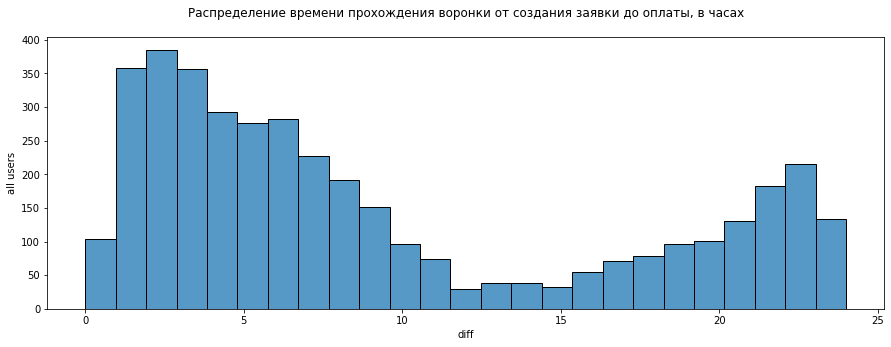

In [89]:
s = events_full_clean.query('description == "Создание заявки" | description == "Оплата"')\
.pivot(index='user_id', columns='description', values='happened_at').reset_index().iloc[:,[0,2,1]]
s['diff'] = round((s['Оплата'] - s['Создание заявки']).dt.seconds / 3600)
plt.figure(figsize=(15,5))
ax = sns.histplot(data = s, x = 'diff', bins=25)
ax.set_ylabel('all users')
ax.set_title('Распределение времени прохождения воронки от создания заявки до оплаты, в часах', pad=20)
plt.show()

In [90]:
round(s.dropna().query('diff <= 60').shape[0] *100 / s.dropna().shape[0],1)

100.0

In [91]:
s['diff'].quantile([0,0.25,0.5,0.75,1])

0.00     0.0
0.25     3.0
0.50     6.0
0.75    17.0
1.00    24.0
Name: diff, dtype: float64

Все клиенты прошли свой CJM в течение 24 часов после создания заявки, половина - в течение первых 6 ч. 

Заказчик будет получать информацию каждое утро, по новым клиентам, создавшим заявку вчера в течение дня, поэтому сдвигать отчетную дату и закладывать дополнительные сутки на прохождение воронки вчерашними клиентами в ущерб актуальности данных не имеет смысла.

In [92]:
report_date = pd.to_datetime('2021-06-16')
time_start = report_date
time_stop = report_date.replace(hour=23, minute=59, second=59, microsecond=999999)
day_report0 = pd.DataFrame({'description': ['Создание заявки', 'Назначение ВУ', 'Выход МВУ на ВУ', 'Успешный ВУ', 'Оплата']})
report = pd.DataFrame()
for i in range(4):
    all_users_per_day = \
    events_full_clean.query('happened_at > @time_start & happened_at < @time_stop').user_id.unique()
    new_users_per_day = set(all_users_per_day)\
    .difference(set(events_full_clean.query('happened_at < @time_start').user_id.unique()))
    day_report = day_report0.merge(events_full_clean[events_full_clean.user_id.isin(new_users_per_day)]\
                            .groupby('description', as_index=False).agg({'user_id':'nunique'})
                            .rename(columns={'user_id':'count'}), on='description', how='left').fillna(0)
    day_report['%'] = round(day_report['count'] *100 / day_report['count'][0], 1) 
    day_report['day'] = (report_date - dt.timedelta(i)).strftime(format='%Y-%m-%d')
    report = pd.concat([report, day_report])
    time_start = time_start - dt.timedelta(1)
    time_stop = time_stop - dt.timedelta(1)
report

,description,count,%,day
0,Создание заявки,713,100.0,2021-06-16
1,Назначение ВУ,679,95.2,2021-06-16
2,Выход МВУ на ВУ,168,23.6,2021-06-16
3,Успешный ВУ,129,18.1,2021-06-16
4,Оплата,127,17.8,2021-06-16
0,Создание заявки,781,100.0,2021-06-15
1,Назначение ВУ,673,86.2,2021-06-15
2,Выход МВУ на ВУ,203,26.0,2021-06-15
3,Успешный ВУ,160,20.5,2021-06-15
4,Оплата,148,19.0,2021-06-15


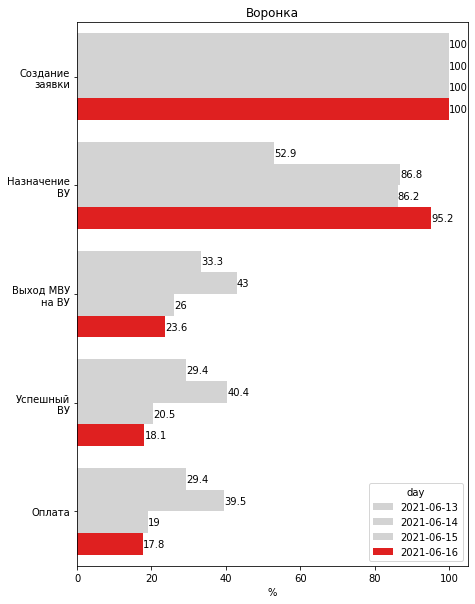

In [93]:
plt.figure(figsize=(7,10))
ax = sns.barplot(data = report,
            y = 'description',
            x = '%',
            hue = 'day',
            hue_order = list(report.day.unique())[-1::-1],
            palette=['lightgrey','lightgrey','lightgrey','red'])
ax.set_ylabel('')
ax.set_title('Воронка')
for container in ax.containers:
    ax.bar_label(container)
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_yticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_yticklabels(labels, rotation=0)
wrap_labels(ax, 10)

### 2.3. Новые платящие пользователи и средний чек

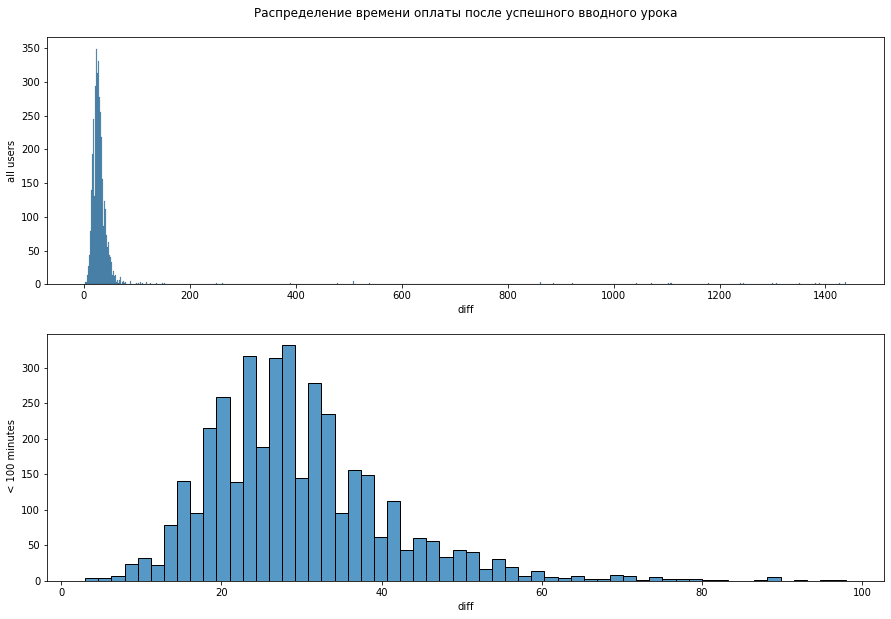

In [94]:
s = events_full_clean.query('description == "Успешный ВУ" | description == "Оплата"')\
.pivot(index='user_id', columns='description', values='happened_at').reset_index().iloc[:,[0,2,1]]
s['diff'] = round((s['Оплата'] - s['Успешный ВУ']).dt.seconds / 60)
fig, ax = plt.subplots(2,1,figsize=(15,10))
sns.histplot(data = s, x = 'diff', ax=ax[0]).set_ylabel('all users')
ax[0].set_title('Распределение времени оплаты после успешного вводного урока', pad=20)
sns.histplot(data = s.query('diff < 100'), x = 'diff', ax=ax[1]).set_ylabel(' < 100 minutes')
plt.show()

In [95]:
round(s.dropna().query('diff <= 60').shape[0] *100 / s.dropna().shape[0],1)

94.1

Ранее было установлено, что весь CJM клиентов занимает не более суток. 

Также установлено, что 94.1% платежеспособных клиентов произвели первую оплату в течение часа после успешного вводного урока, поэтому закладывать какой-либо лаг на оплату также нет необходимости.

In [96]:
report_date = pd.to_datetime('2021-06-16')
time_start = report_date - dt.timedelta(3)
time_stop = report_date.replace(hour=23, minute=59, second=59, microsecond=999999) - dt.timedelta(3)
day_report = pd.DataFrame({'day': list(pd.date_range(report_date-dt.timedelta(3), report_date).strftime('%Y-%m-%d')),
                            'new_users':np.nan * 4, 'total_income':np.nan * 4, 'ARPPU':np.nan * 4})
for i in range(4):
    all_users_per_day = \
    events_full_clean.query('happened_at > @time_start & happened_at < @time_stop').user_id.unique()
    new_users_per_day = set(all_users_per_day)\
    .difference(set(events_full_clean.query('happened_at < @time_start').user_id.unique()))
    all_pay_users_per_day = \
    payments.query('transaction_created_at > @time_start & transaction_created_at < @time_stop').user_id.unique()
    new_pay_users_per_day = set(new_users_per_day)\
    .intersection(set(all_pay_users_per_day))
    
    day_report.iloc[i,1] = len(new_pay_users_per_day)
    day_report.iloc[i,2] = round(payments[(payments.transaction_created_at > time_start) &
                                    (payments.transaction_created_at < time_stop) &
                                    (payments.user_id.isin(new_pay_users_per_day))].amount.sum() / 1000, 1)
    day_report.iloc[i,3] = round(day_report.iloc[i,2] / day_report.iloc[i,1], 2)
    time_start = time_start + dt.timedelta(1)
    time_stop = time_stop + dt.timedelta(1)
    
day_report

,day,new_users,total_income,ARPPU
0,2021-06-13,8.0,411.6,51.45
1,2021-06-14,17.0,695.5,40.91
2,2021-06-15,55.0,1318.5,23.97
3,2021-06-16,44.0,1249.5,28.40


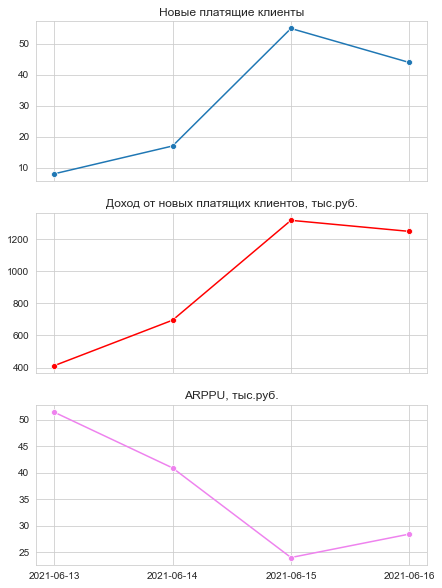

In [97]:
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots(3,1, sharex=True, figsize = (7, 10))
    sns.lineplot(data = day_report, x = 'day', y = 'new_users', ax=ax[0], marker='o')
    sns.lineplot(data = day_report, x = 'day', y = 'total_income', ax=ax[1], color='red', marker='o')
    sns.lineplot(data = day_report, x = 'day', y = 'ARPPU', ax=ax[2], color='violet', marker='o')
    ax[2].set_xlabel('')
    ax[0].set_ylabel('')
    ax[1].set_ylabel('')
    ax[2].set_ylabel('')
    ax[0].set_title('Новые платящие клиенты')
    ax[1].set_title('Доход от новых платящих клиентов, тыс.руб.')
    ax[2].set_title('ARPPU, тыс.руб.')
    plt.show()

### 3. tg-bot и моделирование опыта пользователя отчета

Бот будет отправлять информацию по запросу, чтобы у заказчика была возможность получить информацию на любую дату в случае необходимости дополнительного сопоставления данных за вчера, например, с данными по тому же дню на прошлой неделе, а не только с тремя предшествующими днями. Если во время обсуждения такая опция окажется невостребованной, можно будет перенастроить на отправку отчета по расписанию с помощью run_daily.

In [98]:
dotenv_path = Path(r'C:\Users\Михаил\OneDrive\Документы\Environment variables.env')
load_dotenv(dotenv_path=dotenv_path)
token = os.getenv('token')

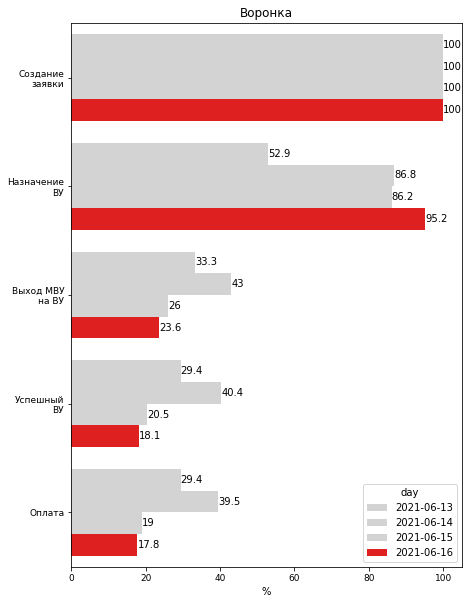

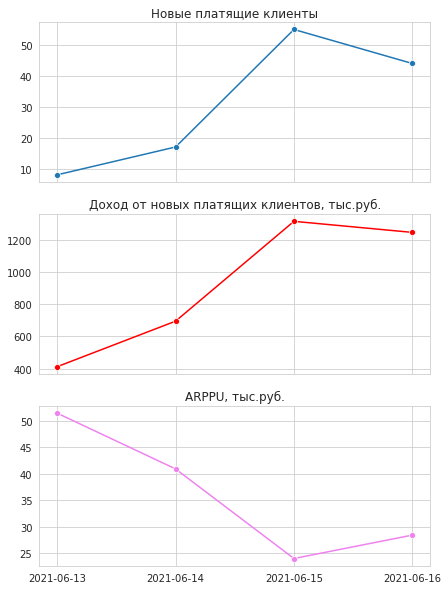

In [99]:
bot = telebot.TeleBot(token, threaded=False)

@bot.message_handler(content_types=['text'])
def get_metrics(message):
    keyboard = types.InlineKeyboardMarkup(); #наша клавиатура
    key_yesterday = types.InlineKeyboardButton(text='на вчера',
    callback_data='yesterday');
    keyboard.add(key_yesterday); #добавляем кнопку в клавиатуру
    key_choose_date= types.InlineKeyboardButton(text='выбрать дату',
    callback_data='choose_date');
    keyboard.add(key_choose_date);
    question = 'Выберите отчетную дату';
    bot.send_message(message.from_user.id, text=question, reply_markup=keyboard)
    bot.register_next_step_handler(message, get_date)
@bot.callback_query_handler(func=lambda call: True)
def callback_worker(call):
    if call.data == 'yesterday':
        date = (dt.datetime.now() - dt.timedelta(1)).date()
        if date in list(events_full_clean.happened_at.dt.date):
            time_start = pd.to_datetime(date)
            time_stop = time_start.replace(hour=23, minute=59, second=59, microsecond=999999)
            day_report0 = pd.DataFrame({'description': ['Создание заявки', 
                                                        'Назначение ВУ', 
                                                        'Выход МВУ на ВУ', 
                                                        'Успешный ВУ', 
                                                        'Оплата']})
            report = pd.DataFrame()
            for i in range(4):
                all_users_per_day = \
                events_full_clean.query('happened_at > @time_start & happened_at < @time_stop').user_id.unique()
                new_users_per_day = set(all_users_per_day)\
                .difference(set(events_full_clean.query('happened_at < @time_start').user_id.unique()))
                day_report = day_report0.merge(events_full_clean[events_full_clean.user_id.isin(new_users_per_day)]\
                                        .groupby('description', as_index=False).agg({'user_id':'nunique'})
                                        .rename(columns={'user_id':'count'}), on='description', how='left').fillna(0)
                day_report['%'] = round(day_report['count'] *100 / day_report['count'][0], 1) 
                day_report['day'] = (pd.to_datetime(date) - dt.timedelta(i)).strftime(format='%Y-%m-%d')
                report = pd.concat([report, day_report])
                time_start = time_start - dt.timedelta(1)
                time_stop = time_stop - dt.timedelta(1)
            plt.figure(figsize=(7,10))
            ax = sns.barplot(data = report,
                        y = 'description',
                        x = '%',
                        hue = 'day',
                        hue_order = list(report.day.unique())[-1::-1],
                        palette=['lightgrey','lightgrey','lightgrey','red'])
            ax.set_ylabel('')
            ax.set_title('Воронка')
            for container in ax.containers:
                ax.bar_label(container)
            wrap_labels(ax, 10)
            ax.tick_params(labelsize=9)
            plt.savefig('q.png')
            bot.send_photo(message.from_user.id, photo=open('C:\\Users\Михаил\!Project Analytics\q.png', 'rb'))

            time_start = pd.to_datetime(date) - dt.timedelta(3)
            time_stop = time_start.replace(hour=23, minute=59, second=59, microsecond=999999)
            day_report = pd.DataFrame({'day': list(pd.date_range(pd.to_datetime(date)-dt.timedelta(3),
                                                                 pd.to_datetime(date)).strftime('%Y-%m-%d')),
                                        'new_users':np.nan * 4, 'total_income':np.nan * 4, 'ARPPU':np.nan * 4})
            for i in range(4):
                all_users_per_day = \
                events_full_clean.query('happened_at > @time_start & happened_at < @time_stop').user_id.unique()
                new_users_per_day = set(all_users_per_day)\
                .difference(set(events_full_clean.query('happened_at < @time_start').user_id.unique()))
                all_pay_users_per_day = \
                payments.query('transaction_created_at > @time_start & transaction_created_at < @time_stop').user_id.unique()
                new_pay_users_per_day = set(new_users_per_day)\
                .intersection(set(all_pay_users_per_day))

                day_report.iloc[i,1] = len(new_pay_users_per_day)
                day_report.iloc[i,2] = round(payments[(payments.transaction_created_at > time_start) &
                                                (payments.transaction_created_at < time_stop) &
                                                (payments.user_id.isin(new_pay_users_per_day))].amount.sum() / 1000, 1)
                day_report.iloc[i,3] = round(day_report.iloc[i,2] / day_report.iloc[i,1], 2)
                time_start = time_start + dt.timedelta(1)
                time_stop = time_stop + dt.timedelta(1)
            with sns.axes_style("whitegrid"):
                fig, ax = plt.subplots(3,1, sharex=True, figsize = (7, 10))
                sns.lineplot(data = day_report, x = 'day', y = 'new_users', ax=ax[0], marker='o')
                sns.lineplot(data = day_report, x = 'day', y = 'total_income', ax=ax[1], color='red', marker='o')
                sns.lineplot(data = day_report, x = 'day', y = 'ARPPU', ax=ax[2], color='violet', marker='o')
                ax[2].set_xlabel('')
                ax[0].set_ylabel('')
                ax[1].set_ylabel('')
                ax[2].set_ylabel('')
                ax[0].set_title('Новые пользователи')
                ax[1].set_title('Общий доход, тыс.руб.')
                ax[2].set_title('ARPPU, тыс.руб.')
            plt.savefig('w.png')
            bot.send_photo(message.from_user.id, photo=open('C:\\Users\Михаил\!Project Analytics\w.png', 'rb'))
        else:
            bot.send_message(call.message.chat.id, 'такой даты нет в базе');
    elif call.data == 'choose_date':
        mes = 'введите дату в формате yyyy-mm-dd'
        bot.send_message(call.message.chat.id, mes);
        date = ''
@bot.message_handler(content_types=['text'])
def get_date(message):
    global date
    date = message.text
    try:
        pd.to_datetime(date)
    except Exception:
        bot.send_message(message.from_user.id, 'неверный формат')
    real_date = pd.to_datetime(date)
    if (real_date >= events_full_clean.happened_at.min()) & (real_date <= events_full_clean.happened_at.max()):
        time_start = pd.to_datetime(date)
        time_stop = time_start.replace(hour=23, minute=59, second=59, microsecond=999999)
        day_report0 = pd.DataFrame({'description': ['Создание заявки', 
                                                    'Назначение ВУ', 
                                                    'Выход МВУ на ВУ', 
                                                    'Успешный ВУ', 
                                                    'Оплата']})
        report = pd.DataFrame()
        for i in range(4):
            all_users_per_day = \
            events_full_clean.query('happened_at > @time_start & happened_at < @time_stop').user_id.unique()
            new_users_per_day = set(all_users_per_day)\
            .difference(set(events_full_clean.query('happened_at < @time_start').user_id.unique()))
            day_report = day_report0.merge(events_full_clean[events_full_clean.user_id.isin(new_users_per_day)]\
                                    .groupby('description', as_index=False).agg({'user_id':'nunique'})
                                    .rename(columns={'user_id':'count'}), on='description', how='left').fillna(0)
            day_report['%'] = round(day_report['count'] *100 / day_report['count'][0], 1) 
            day_report['day'] = (pd.to_datetime(date) - dt.timedelta(i)).strftime(format='%Y-%m-%d')
            report = pd.concat([report, day_report])
            time_start = time_start - dt.timedelta(1)
            time_stop = time_stop - dt.timedelta(1)
        plt.figure(figsize=(7,10))
        ax = sns.barplot(data = report,
                    y = 'description',
                    x = '%',
                    hue = 'day',
                    hue_order = list(report.day.unique())[-1::-1],
                    palette=['lightgrey','lightgrey','lightgrey','red'])
        ax.set_ylabel('')
        ax.set_title('Воронка')
        for container in ax.containers:
            ax.bar_label(container)
        wrap_labels(ax, 10)
        ax.tick_params(labelsize=9)
        plt.savefig('q.png')
        bot.send_photo(message.from_user.id, photo=open('C:\\Users\Михаил\!Project Analytics\q.png', 'rb'))

        time_start = pd.to_datetime(date) - dt.timedelta(3)
        time_stop = time_start.replace(hour=23, minute=59, second=59, microsecond=999999)
        day_report = pd.DataFrame({'day': list(pd.date_range(pd.to_datetime(date)-dt.timedelta(3),
                                                             pd.to_datetime(date)).strftime('%Y-%m-%d')),
                                    'new_users':np.nan * 4, 'total_income':np.nan * 4, 'ARPPU':np.nan * 4})
        for i in range(4):
            all_users_per_day = \
            events_full_clean.query('happened_at > @time_start & happened_at < @time_stop').user_id.unique()
            new_users_per_day = set(all_users_per_day)\
            .difference(set(events_full_clean.query('happened_at < @time_start').user_id.unique()))
            all_pay_users_per_day = \
            payments.query('transaction_created_at > @time_start & transaction_created_at < @time_stop').user_id.unique()
            new_pay_users_per_day = set(new_users_per_day)\
            .intersection(set(all_pay_users_per_day))

            day_report.iloc[i,1] = len(new_pay_users_per_day)
            day_report.iloc[i,2] = round(payments[(payments.transaction_created_at > time_start) &
                                            (payments.transaction_created_at < time_stop) &
                                            (payments.user_id.isin(new_pay_users_per_day))].amount.sum() / 1000, 1)
            day_report.iloc[i,3] = round(day_report.iloc[i,2] / day_report.iloc[i,1], 2)
            time_start = time_start + dt.timedelta(1)
            time_stop = time_stop + dt.timedelta(1)
        with sns.axes_style('whitegrid'):
            fig, ax = plt.subplots(3,1, sharex=True, figsize = (7, 10))
            sns.lineplot(data = day_report, x = 'day', y = 'new_users', ax=ax[0], marker='o')
            sns.lineplot(data = day_report, x = 'day', y = 'total_income', ax=ax[1], color='red', marker='o')
            sns.lineplot(data = day_report, x = 'day', y = 'ARPPU', ax=ax[2], color='violet', marker='o')
            ax[2].set_xlabel('')
            ax[0].set_ylabel('')
            ax[1].set_ylabel('')
            ax[2].set_ylabel('')
            ax[0].set_title('Новые платящие клиенты')
            ax[1].set_title('Доход от новых платящих клиентов, тыс.руб.')
            ax[2].set_title('Средний чек, тыс.руб.')
        plt.savefig('w.png')
        bot.send_photo(message.from_user.id, photo=open('C:\\Users\Михаил\!Project Analytics\w.png', 'rb'))
    else:
        bot.send_message(message.from_user.id, 'такой даты нет в базе');

bot.polling(none_stop=True, interval=0)

На основании полученных графиков по состоянию на 16 июня 2021 г. руководитель отдела продаж может сделать следующие выводы:

1) При росте процента назначенных вводных уроков, процент выхода методиста на вводный урок падает последние три дня, аналогично и процент состоявшихся вводных уроков и, как следствие, оплат. 

Возможно, методисты не справляются с возросшей нагрузкой или растет число отказов от проведения вводного урока, после его назначения со стороны клиентов. Скорее всего, упрощен алгоритм назначения вводного урока, как следствие, снижена "ответственность" клиентов за его посещение. Это нужно обсудить с техническим отделом, маркетингом и методическим отделом.

2) В последние дни наблюдался рост числа новых платящих клиентов, но вчера произошел небольшой спад. В предыдущие дни соответственно рос и доход от новых клиентов, однако, темпы роста дохода отставали от темпов роста числа клиентов, что показывает отрицательная динамика графика ARPPU в эти дни. Рост среднего чека вчера позволил слегка сгладить падение доходов от новых клиентов, количество которых уменьшилось.

Скорее всего в предыдущие дни действовала скидочная акция для новых клиентов, поэтому средний чек просел. С точки зрения роста дохода эта акция была успешной, однако, чтобы сохранить этот рост, сейчас следует сосредоточиться на увеличении среднего чека - повысить цены или ввести платные доп.услуги. Это также необходимо обсудить с маркетингом.